# Boilerplate
Imports libraries, initializes variables
*(This can only be done once per kernel init)*

In [38]:
#picam2 imaging
from picamera2 import Picamera2, Preview
from libcamera import Transform, controls
import time

#analysis
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.ndimage import gaussian_filter
from scipy import ndimage

from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.morphology import dilation
from skimage.feature import canny
from skimage.filters import sobel
from skimage.segmentation import watershed

In [2]:
#creates picam2 object
picam2 = Picamera2()

[1:36:43.548331542] [3163]  INFO Camera camera_manager.cpp:327 libcamera v0.4.0+53-29156679
[1:36:43.678490674] [3182]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[1:36:43.687967200] [3182]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media3 and ISP device /dev/media0
[1:36:43.688105012] [3182]  INFO RPI pipeline_base.cpp:1121 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'


# Image Capture
Creates preview screen with parameters, then starts the service and takes a picture

In [3]:
#preview config params
picam2.preview_configuration.size = (800, 600)
picam2.preview_configuration.format = "YUV420"
picam2.preview_configuration.transform=Transform(hflip=True, vflip=True)

#still image capture config params
picam2.still_configuration.size = (800, 600)
picam2.still_configuration.enable_raw()
picam2.still_configuration.raw.size = picam2.sensor_resolution
picam2.still_configuration.transform=Transform(hflip=True, vflip=True)
picam2.title_fields = ["ExposureTime", "AnalogueGain"]

#capture config params for array capture
#capture_config = picam2.create_still_configuration()

In [4]:
# starts picam2 service, autofocus
picam2.start("preview", show_preview=True)
picam2.set_controls({"AfMode": controls.AfModeEnum.Continuous})

#time for camera to autofocus
time.sleep(2)

#captures still as numpy array, metadata as python dictionary
array = picam2.switch_mode_and_capture_array("still", "main")
metadata = picam2.capture_metadata()

# this saves still as an image
#picam2.switch_mode_and_capture_file("still", "test_full2.jpg")

[1:36:43.846330911] [3163]  INFO Camera camera.cpp:1202 configuring streams: (0) 800x600-YUV420 (1) 1536x864-SRGGB10_CSI2P
[1:36:43.847409605] [3182]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SRGGB10_1X10 - Selected unicam format: 1536x864-pRAA
[1:37:03.812953028] [3186]  INFO Camera camera.cpp:1202 configuring streams: (0) 800x600-BGR888 (1) 4608x2592-SRGGB10_CSI2P
[1:37:03.818570194] [3182]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 4608x2592-SRGGB10_1X10 - Selected unicam format: 4608x2592-pRAA
[1:37:04.210217430] [3186]  INFO Camera camera.cpp:1202 configuring streams: (0) 800x600-YUV420 (1) 1536x864-SRGGB10_CSI2P
[1:37:04.228682723] [3182]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SRGGB10_1X10 - Selected unicam format: 1536x864-pRAA


In [5]:
#closes picam functions
picam2.stop()
picam2.stop_preview()

# Image Analysis
Uses OpenCV, Numpy, and Matplotlib for SPACE JUNK SCIENCE!

In [6]:
#obs = array[500:2000, 1350:3100, 0]
#obs = array[0:600, 0:800, 1]
obs = array
obs_red = array[0:600, 0:800, 0]

In [7]:
obs.shape

(600, 800, 3)

In [8]:
obs.ndim

3

In [9]:
# histogram of array levels (not connected to rgb?)
#plt.hist(array.ravel(), bins=range(256), fc='k', ec='k')

In [10]:
image = img_as_float(obs_red)
mask = gaussian_filter(image, 1)
mask = image

In [11]:
h = 0.4
seed = image - h
dilated = reconstruction(seed, mask, method='dilation')

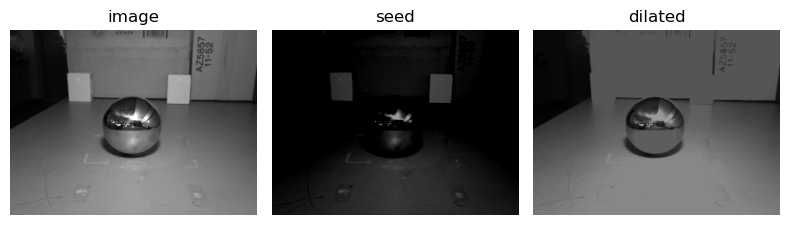

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))

ax0.imshow(image, vmin=image.min(), vmax=image.max(), cmap='gray')
ax0.set_title('image')
ax0.axis('off')

ax1.imshow(seed, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('seed')
ax1.axis('off')

ax2.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax2.set_title('dilated')
ax2.axis('off')


fig.tight_layout()
plt.show()

In [13]:
#canny edge detection
#edges = canny(dilated)
#edge_fill = ndimage.binary_fill_holes(edges)

In [59]:
markers = np.zeros_like(image)
markers[dilated < 0.80] = 1
markers[dilated > 0.90] = 2
print(markers)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [60]:
sobel_map = sobel(dilated)

In [61]:
segmentation = watershed(sobel_map, markers)

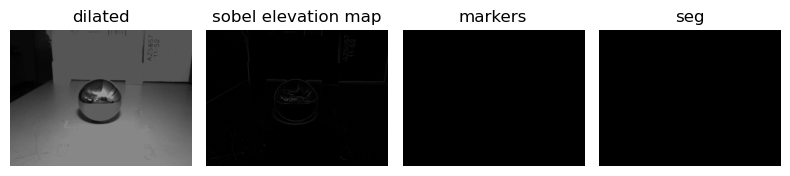

In [62]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(8, 2.5))


ax0.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax0.set_title('dilated')
ax0.axis('off')

ax1.imshow(sobel_map, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('sobel elevation map')
ax1.axis('off')

ax2.imshow(markers, cmap='nipy_spectral')
ax2.set_title('markers')
ax2.axis('off')

ax3.imshow(segmentation, cmap='gray')
ax3.set_title('seg')
ax3.axis('off')

fig.tight_layout()
plt.show()

In [17]:
disk = morphology.disk(5)
#print('disk = \n', disk)

NameError: name 'morphology' is not defined

In [ ]:
#distmask = np.copy(mask)
#distmask[distmask < 0.90] = 0
#distmask[distmask > 0.90] = 1
#struct1 = ndimage.generate_binary_structure(2, 1)
#dist = ndimage.binary_dilation(distmask, structure=disk, iterations=1).astype(distmask.dtype)

#fig, ax = plt.subplots()
#ax.imshow(distmask, vmin=image.min(), vmax=image.max(), cmap='gray')
#fig.tight_layout()
#plt.show()

In [ ]:
#dist = dilation(dilated, disk)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(dist, vmin=image.min(), vmax=image.max(), cmap='gray')
fig.tight_layout()
plt.show()

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 275

ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.set_ylim(-0.2, 2)
ax0.set_title('image slice')
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
#sharex=True, sharey=True, 
#width_ratios=[6, 6], height_ratios=[9, 9]

axs[0, 0].imshow(obs)
axs[0, 0].set_title('RGB Band Composite')

axs[0, 1].imshow(obs[0:600, 0:800, 0], cmap='Reds_r')
axs[0, 1].set_title('Red Band')

axs[1, 0].imshow(obs[0:600, 0:800, 1], cmap='Greens_r')
axs[1, 0].set_title('Green Band')

axs[1, 1].imshow(obs[0:600, 0:800, 2], cmap='Blues_r')
axs[1, 1].set_title('Blue Band')

for ax in axs.flat:
    ax.set(xlabel='x (800px)', ylabel='y (600px)')

plt.text(x=0.5, y=0.88, s="Opala-1 Band Filters", fontsize=18, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.81, s="R ≈ 550nm-800nm\nG ≈ 450nm-625nm\nB ≈ 350nm-550nm", fontsize=10, ha="center", transform=fig.transFigure)
plt.subplots_adjust(top=0.8, wspace=0.3)
    
plt.show()

#fig.savefig("Band_Filters_Alt.png", dpi=300)
#nipy_spectral